In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充3.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']


## 模型4.0版本（增加卷积核遍历）



In [2]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义重要特征列
important_features = ['GMT_0900_PAR', 'GMT_0600_PAR', 'GMT_0300_PAR',  'GMT_0000_PAR','FAI', 'ndvi', 'nrfi', 
                     'MPAR', 'PDVI', 'DAPAR', 'PPDI']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备序列数据
def create_sequences(data, features, seq_length=15):
    X, y = [], []
    feature_data = data[features].values
    target_data = data[['density_mean', 'density_lower', 'density_upper']].values
    
    for i in range(len(data) - seq_length):
        X.append(feature_data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# 准备训练集和测试集序列数据
seq_length = 20
X_train, y_train = create_sequences(train_df, important_features, seq_length)
X_test, y_test = create_sequences(test_df, important_features, seq_length)

# 添加数据标准化
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 导入必要的库
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dropout, Dense, Input, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model

def residual_block(x, dilation_rate, n_filters, kernel_size):
    dropout_rate = 0.3  # 降低dropout比例
    
    # 残差分支
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    r = BatchNormalization()(r)  # 添加BatchNormalization
    r = LayerNormalization()(r)
    r = Activation('selu')(r)
    r = Dropout(dropout_rate)(r)
    
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(r)
    r = BatchNormalization()(r)  # 添加BatchNormalization
    r = LayerNormalization()(r)
    r = Activation('selu')(r)
    r = Dropout(dropout_rate)(r)
    
    if x.shape[-1] != n_filters:
        x = Conv1D(n_filters, 1, padding='same')(x)
        
    return Add()([x, r])

# 构建TCN模型
input_layer = Input(shape=(seq_length, len(important_features)))
x = input_layer

# 修改扩张率增长速度
kernel_sizes = [7]
# kernel_sizes = [7, 10]
best_val_loss = float('inf')
best_kernel_size = None
best_model = None

for kernel_size in kernel_sizes:
    print(f"\n测试卷积核大小: {kernel_size}")
    
    n_filters = 64 * kernel_size
    dilations = [1, 2, 3, 4, 6, 8]  # 减小扩张率增长速度
    
    x = input_layer
    for d in dilations:
        x = residual_block(x, d, n_filters, kernel_size)
        
    x = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(x)
    
    dense_units = n_filters // 2
    x = Dense(dense_units, activation='selu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(dense_units//2, activation='selu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(dense_units//4, activation='selu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    output_layer = Dense(3, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 降低学习率
    model.compile(optimizer=optimizer, loss='huber')  # 使用Huber损失
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001
    )
    
    history = model.fit(
        X_train_scaled, y_train_scaled,  # 使用标准化后的数据
        epochs=500,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_kernel_size = kernel_size
        best_model = model

print(f"\n最佳卷积核大小: {best_kernel_size}")
print(f"最佳验证损失: {best_val_loss:.6f}")

# 使用最佳模型进行预测并反标准化
predictions_scaled = best_model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

y_mean_pred = predictions[:, 0]
y_lower_pred = predictions[:, 1]
y_upper_pred = predictions[:, 2]


2024-10-31 14:41:08.358159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 14:41:08.598993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 14:41:08.692316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 14:41:08.718786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 14:41:08.920014: I tensorflow/core/platform/cpu_feature_guar


测试卷积核大小: 7


I0000 00:00:1730356871.958244   13134 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 14:41:12.319653: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 739ms/step - loss: 0.9330 - val_loss: 1.8592 - learning_rate: 1.0000e-04
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 627ms/step - loss: 0.8685 - val_loss: 1.2883 - learning_rate: 1.0000e-04
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 622ms/step - loss: 0.7691 - val_loss: 0.8130 - learning_rate: 1.0000e-04
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 632ms/step - loss: 0.7479 - val_loss: 0.6632 - learning_rate: 1.0000e-04
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 643ms/step - loss: 0.7298 - val_loss: 0.6466 - learning_rate: 1.0000e-04
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 622ms/step - loss: 0.6415 - val_loss: 0.6264 - learning_rate: 1.0000e-04
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 610ms/step - loss: 0.6648 - val_loss: 0.5801 - learning_rate: 1.0000e-04
Epoch 8/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 627ms/step - loss: 0.6086 - val_loss: 0.5389 - learning_rate: 1.0000e-04
Epoch 9/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 638ms/step - loss: 0.6277 - v

/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/3724871750.py:23: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.

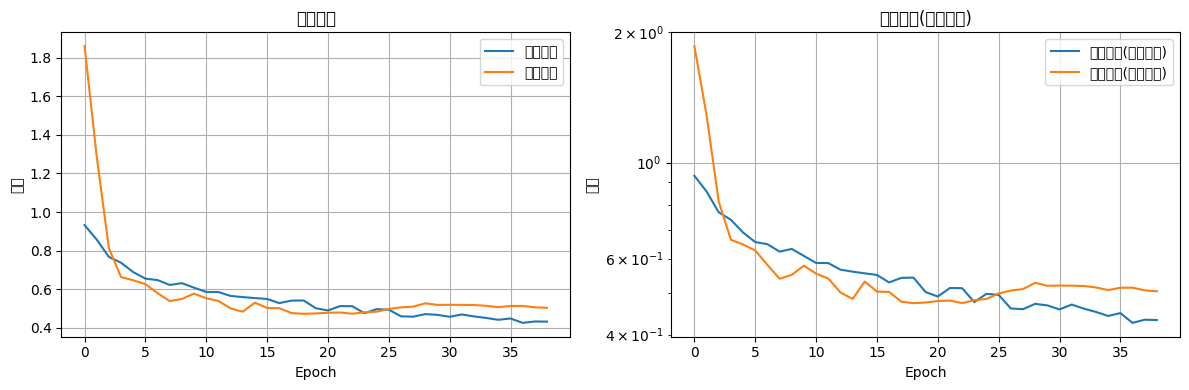


最终训练损失: 0.432441
最终验证损失: 0.503985
最佳验证损失: 0.472998


In [3]:

# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='训练损失(对数尺度)')
plt.plot(history.history['val_loss'], label='验证损失(对数尺度)')
plt.yscale('log')
plt.title('模型损失(对数尺度)')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印最终的训练和验证损失
print(f"\n最终训练损失: {history.history['loss'][-1]:.6f}")
print(f"最终验证损失: {history.history['val_loss'][-1]:.6f}")
print(f"最佳验证损失: {min(history.history['val_loss']):.6f}")


/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13134/891806621.py:38: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_l


R2 分数:
平均密度: -3.9446
下限密度: -2.9690
上限密度: -7.0103


/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

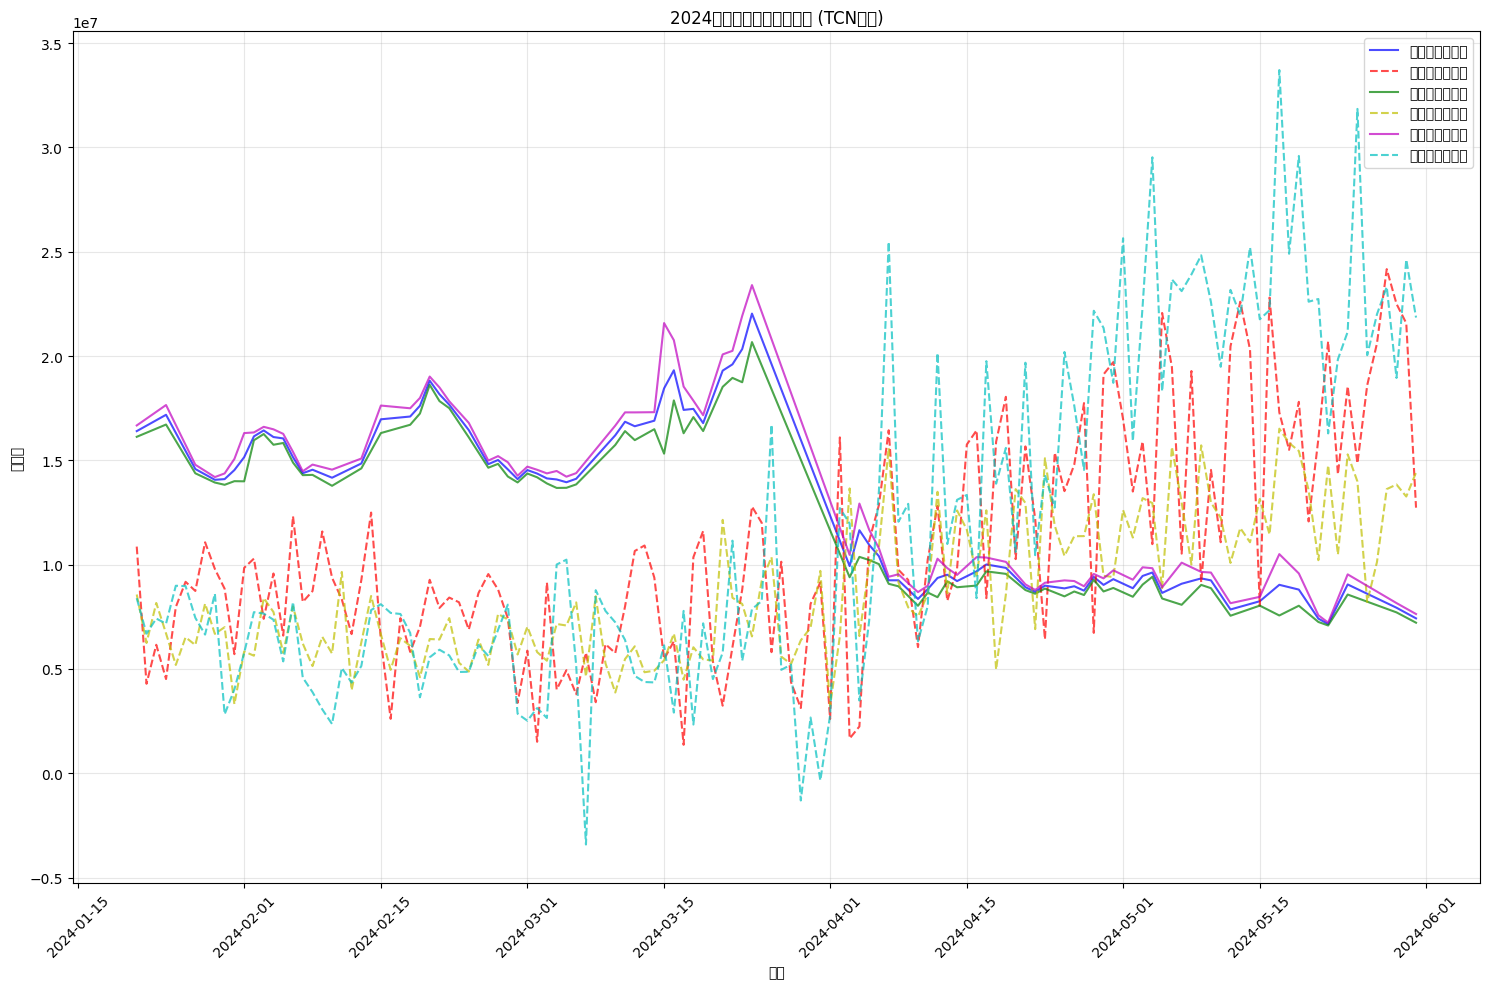

In [4]:

# 计算R2分数
r2_mean = r2_score(y_test[:, 0], y_mean_pred)
r2_lower = r2_score(y_test[:, 1], y_lower_pred)
r2_upper = r2_score(y_test[:, 2], y_upper_pred)

print("\nR2 分数:")
print(f"平均密度: {r2_mean:.4f}")
print(f"下限密度: {r2_lower:.4f}")
print(f"上限密度: {r2_upper:.4f}")

# 绘制测试集的预测结果
plt.figure(figsize=(15, 10))

# 调整日期索引以匹配序列预测结果
test_dates = test_df['date'].iloc[seq_length:]

# 绘制实际值和预测值
plt.plot(test_dates, y_test[:, 0], 'b-', label='平均密度实际值', alpha=0.7)
plt.plot(test_dates, y_mean_pred, 'r--', label='平均密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 1], 'g-', label='下限密度实际值', alpha=0.7)
plt.plot(test_dates, y_lower_pred, 'y--', label='下限密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 2], 'm-', label='上限密度实际值', alpha=0.7)
plt.plot(test_dates, y_upper_pred, 'c--', label='上限密度预测值', alpha=0.7)

# 添加标题和标签
plt.title('2024年藻密度预测结果对比 (TCN模型)')
plt.xlabel('日期')
plt.ylabel('藻密度')
plt.legend()

# 旋转x轴日期标签以提高可读性
plt.xticks(rotation=45)

# 显示网格
plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()